In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Constants
SPLIT_THRESHOLD = 0.8


In [2]:
# Load squid data
squid_df = pd.read_excel('../dataset/squid-tweets/squid-dataset-cleaned.xlsx').drop('Unnamed: 0', axis=1).astype({'is-spam': np.float64})
squid_df.tail()

DF_LENGTH = squid_df.shape[0]

In [3]:
# Train-test split
draw = squid_df.sample(frac=1.0, random_state=42)
squid_train = draw[:int(SPLIT_THRESHOLD*DF_LENGTH)]
squid_valid = draw[int(SPLIT_THRESHOLD*DF_LENGTH):]

In [4]:
squid_valid.tail()

,tweets,is-spam
106,<username> If anything them banning it made it...,0.0
270,SQUID GAME\nepisode 1: c’monnnn let’s get to t...,0.0
860,New Drop Collection!💥\nFor fans of the series ...,1.0
435,<username> <username> not everyone was equal i...,0.0
102,WHERE'S MY SQUID GAME MEME REFERENCING OUR NEW...,1.0


In [5]:
# Load NLP stuff
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(squid_train['tweets'])

# Variables
dict_size = len(tokenizer.word_index)

print('Length: {}'.format(dict_size))
tokenizer.word_index

Length: 3152


{'<OOV>': 1,
 'game': 2,
 'squid': 3,
 'the': 4,
 'link': 5,
 'username': 6,
 'hashtag': 7,
 'i': 8,
 'to': 9,
 'and': 10,
 'a': 11,
 'of': 12,
 'is': 13,
 'in': 14,
 'it': 15,
 'for': 16,
 'you': 17,
 'on': 18,
 'that': 19,
 'but': 20,
 'was': 21,
 'my': 22,
 'this': 23,
 'with': 24,
 'just': 25,
 'me': 26,
 'from': 27,
 'like': 28,
 'are': 29,
 'so': 30,
 'about': 31,
 'be': 32,
 'have': 33,
 'as': 34,
 'not': 35,
 'at': 36,
 'watching': 37,
 'if': 38,
 'get': 39,
 'by': 40,
 'people': 41,
 'they': 42,
 'what': 43,
 'how': 44,
 'one': 45,
 'we': 46,
 'show': 47,
 'when': 48,
 'know': 49,
 'all': 50,
 'episode': 51,
 'up': 52,
 'out': 53,
 'why': 54,
 'do': 55,
 'no': 56,
 'watch': 57,
 'now': 58,
 'your': 59,
 'more': 60,
 'new': 61,
 'or': 62,
 'see': 63,
 'netflix': 64,
 'watched': 65,
 'an': 66,
 'he': 67,
 'really': 68,
 'would': 69,
 'good': 70,
 'some': 71,
 'finished': 72,
 'i’m': 73,
 'halloween': 74,
 'will': 75,
 'got': 76,
 '1': 77,
 'because': 78,
 'has': 79,
 'creator': 

In [6]:
squid_train_seq = tokenizer.texts_to_sequences(squid_train['tweets'])
squid_train_pad = tf.keras.preprocessing.sequence.pad_sequences(squid_train_seq, padding='pre', maxlen=60)

squid_valid_seq = tokenizer.texts_to_sequences(squid_valid['tweets'])
squid_valid_pad = tf.keras.preprocessing.sequence.pad_sequences(squid_valid_seq, padding='pre', maxlen=60, truncating='post')

In [7]:
squid_valid_pad

array([[  0,   0,   0, ...,  12,   3,   2],
       [  0,   0,   0, ...,   8, 138,   1],
       [  0,   0,   0, ...,  14,  15,   1],
       ...,
       [  0,   0,   0, ...,   7,   7,   5],
       [  0,   0,   0, ...,  57,   4,  47],
       [  0,   0,   0, ...,   1,   1,   5]], dtype=int32)

In [8]:
PAD_MAX_LENGTH = 60

In [12]:
# Load model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index), 16, input_length=PAD_MAX_LENGTH),
    # tf.keras.layers.LSTM(8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 16)            50432     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 56,257
Trainable params: 56,257
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(squid_train_pad, y=squid_train['is-spam'].values, epochs=190, batch_size=16, validation_data=(squid_valid_pad, squid_valid['is-spam'].values), verbose=2)

Epoch 1/190
52/52 - 4s - loss: 0.6937 - binary_accuracy: 0.4286 - val_loss: 0.6940 - val_binary_accuracy: 0.3366
Epoch 2/190
52/52 - 1s - loss: 0.6933 - binary_accuracy: 0.4835 - val_loss: 0.6936 - val_binary_accuracy: 0.4098
Epoch 3/190
52/52 - 1s - loss: 0.6929 - binary_accuracy: 0.5495 - val_loss: 0.6933 - val_binary_accuracy: 0.5317
Epoch 4/190
52/52 - 1s - loss: 0.6925 - binary_accuracy: 0.6007 - val_loss: 0.6930 - val_binary_accuracy: 0.5512
Epoch 5/190
52/52 - 1s - loss: 0.6921 - binary_accuracy: 0.6337 - val_loss: 0.6926 - val_binary_accuracy: 0.6195
Epoch 6/190
52/52 - 1s - loss: 0.6915 - binary_accuracy: 0.6166 - val_loss: 0.6921 - val_binary_accuracy: 0.6244
Epoch 7/190
52/52 - 1s - loss: 0.6910 - binary_accuracy: 0.6007 - val_loss: 0.6916 - val_binary_accuracy: 0.6000
Epoch 8/190
52/52 - 1s - loss: 0.6904 - binary_accuracy: 0.6007 - val_loss: 0.6910 - val_binary_accuracy: 0.6000
Epoch 9/190
52/52 - 1s - loss: 0.6899 - binary_accuracy: 0.6007 - val_loss: 0.6905 - val_binary_

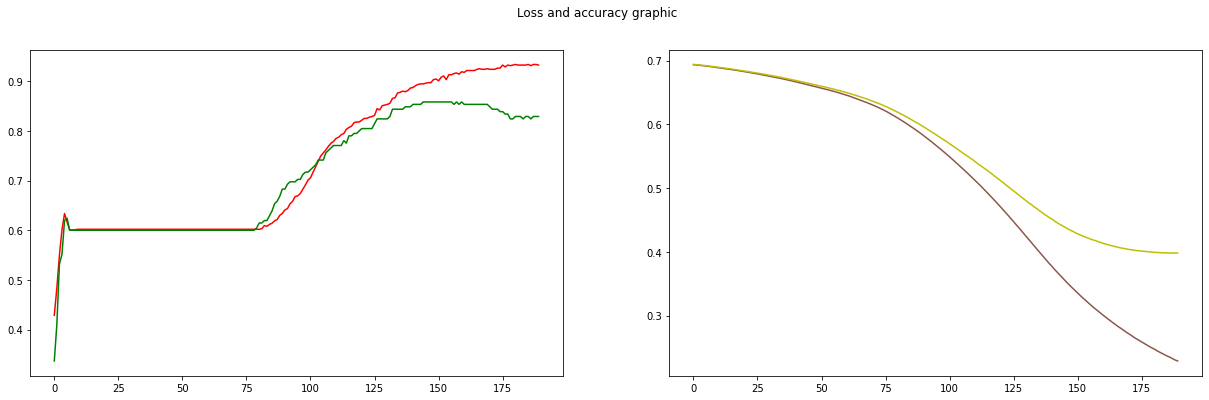

In [14]:
plt.rcParams['figure.figsize'] = (21,6)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Loss and accuracy graphic')
axs[0].plot(range(len(history.history['loss'])), history.history['binary_accuracy'], 'r-', history.history['val_binary_accuracy'], 'g-')
axs[1].plot(range(len(history.history['loss'])), history.history['loss'], 'tab:brown', history.history['val_loss'], 'y')
plt.show()

In [15]:
model.save('../model/squid-spam-model')

2021-10-28 14:43:49.080656: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/squid-spam-model/assets


INFO:tensorflow:Assets written to: ../model/squid-spam-model/assets


In [16]:
# Saving tokenizer via pickle
import pickle
with open('../dataset/squid-tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)